In [ ]:
#Supplementary computer code accompanying Hoyal Cuthill, Guttenberg, Ledger, Crowther and Huertas (2019) 
#Deep learning on butterfly phenotypes tests evolution’s oldest mathematical model. Science Advances. 
#Please cite this paper in reference to this code.

In [12]:
%pylab inline

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import glob
import sys

from math import *

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim
from torch.autograd import Variable
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import copy

from PIL import Image

from IPython import display
import time

import pickle

import scipy.cluster.hierarchy as sch

def tovar(x):
    return Variable(torch.FloatTensor(x).cuda(), requires_grad = False)

def toivar(x):
    return Variable(torch.LongTensor(x).cuda(), requires_grad = False)

Populating the interactive namespace from numpy and matplotlib


/home/nichg/.local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['fabs', 'radians', 'exp', 'copysign', 'log1p', 'pi', 'display', 'gamma', 'fmod', 'sinh', 'ceil', 'e', 'inf', 'isfinite', 'isnan', 'cos', 'log', 'log10', 'degrees', 'tan', 'trunc', 'frexp', 'log2', 'isinf', 'ldexp', 'isclose', 'nan', 'sqrt', 'copy', 'tanh', 'modf', 'sin', 'expm1', 'floor', 'cosh', 'hypot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
class Embed(nn.Module):
    def __init__(self):
        super(Embed,self).__init__()
        
        self.conv1 = nn.Conv2d(3,32,9,padding=4)
        torch.nn.init.orthogonal(self.conv1.weight)

        self.p1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32,96,3,padding=1)
        torch.nn.init.orthogonal(self.conv2.weight)
        self.conv2b = nn.Conv2d(96,48,1)
        torch.nn.init.orthogonal(self.conv2b.weight)
        self.p2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(48,128,3,padding=1)
        torch.nn.init.orthogonal(self.conv3.weight)
        self.conv3b = nn.Conv2d(128,64,1)
        torch.nn.init.orthogonal(self.conv3b.weight)        
        self.p3 = nn.MaxPool2d(2)
        
        self.conv4 = nn.Conv2d(64,96,3,padding=1)
        torch.nn.init.orthogonal(self.conv4.weight)        
        self.p4 = nn.MaxPool2d(2)
        
        self.conv5 = nn.Conv2d(96,128,3,padding=1)
        torch.nn.init.orthogonal(self.conv5.weight)        
        self.conv6 = nn.Conv2d(128,128,3,padding=1)
        torch.nn.init.orthogonal(self.conv6.weight)        
        self.p5 = nn.MaxPool2d(2)
        
        self.dense1 = nn.Linear(10*128,256)
        self.dense2 = nn.Linear(256,256)
        self.dense3 = nn.Linear(256,64)
        
    def inter(self, x):
        z = self.p1(F.elu(self.conv1(x)))
        #z = self.p2(F.elu(self.conv2b(F.elu(self.conv2(z)))))
        #z = self.p3(F.elu(self.conv3b(F.elu(self.conv3(z)))))
        #z = self.p4(F.elu(self.conv4(z)))
        
        #z = F.elu(self.conv5(z))
        #z = z + F.elu(self.conv6(z))
        
        return z

    def forward(self, x):
        z = self.p1(F.elu(self.conv1(x)))
        z = self.p2(F.elu(self.conv2b(F.elu(self.conv2(z)))))
        z = self.p3(F.elu(self.conv3b(F.elu(self.conv3(z)))))
        z = self.p4(F.elu(self.conv4(z)))
        
        z = F.elu(self.conv5(z))
        z = z + F.elu(self.conv6(z))
        z = self.p5(z)
        
        s = z.size()
        z = z.permute(0,1,2,3).contiguous().view(s[0],s[1]*s[2]*s[3])
        
        z = F.elu(self.dense1(z))
        z = F.elu(self.dense2(z))
        z = self.dense3(z)
        
        z = z / torch.sqrt(torch.sum(z**2,1,keepdim=True)+1e-16)
        
        return z
        
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.embed = Embed()
        self.dense1 = nn.Linear(64,96)
        self.drop1 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(96,96)
        self.drop2 = nn.Dropout(0.5)
        self.dense3 = nn.Linear(96,96)
        self.drop3 = nn.Dropout(0.5)
        self.dense4 = nn.Linear(96,38)
        
        self.adam = torch.optim.Adam(self.parameters(), lr=1e-4)
        
    def get_embedding(self,x):
        return self.embed(x)
    
    def predict(self, z):
        z = self.drop1(F.elu(self.dense1(z)))
        z = self.drop2(F.elu(self.dense2(z)))
        z = self.drop3(F.elu(self.dense3(z)))
        p = F.softmax(self.dense4(z),dim=1)
        
        return p
        
    def forward(self,x1,x2,x3):
        z1 = self.get_embedding(x1)
        z2 = self.get_embedding(x2)
        z3 = self.get_embedding(x3)
        
        p = self.predict(z1)
        
        return p,z1,z2,z3    

    def triplet(self,z1,z2,z3):
        return torch.mean((z1-z2)**2) - torch.mean((z1-z3)**2)
    
    def loss(self,p,z1,z2,z3,y):
        tloss = self.triplet(z1,z2,z3)
        
        p = torch.clamp(p,1e-6,1-1e-6)
        idx = torch.LongTensor(np.arange(p.size()[0])).cuda()        
        loss = torch.mean(-torch.log(p[idx,y[idx]]))
        
        reg = 0
        for param in self.parameters():
            reg = reg + torch.mean(param**2)
            
        loss = loss + 6e-5*reg + 0.1 * tloss
        
        return loss


In [9]:
LOAD_PRETRAINED = True

net = Net().cuda()

if LOAD_PRETRAINED:
    net.load_state_dict(torch.load("butterflynet.pth"))

In [4]:
### Convert from Theano

#tparams = pickle.load(open("../butterflynet_subspecies.params","rb"))
#for lp, thp in zip(tparams,net.parameters()):
#    if len(lp.shape)==1:
#        thp.data = torch.FloatTensor(lp).cuda()
#    if len(lp.shape)==2:
#        thp.data = torch.FloatTensor(lp.transpose()).cuda()
#    if len(lp.shape)==4:
#        thp.data = torch.FloatTensor(lp.transpose(0,1,2,3)[:,:,::-1,::-1].copy()).cuda()
#        
#    print(lp.shape, thp.size())

In [5]:
index = pd.read_csv("data/SimplifiedDatabase.txt", sep='\t')

data = []
tlabels = []

for i in range(index.shape[0]):
    im = np.array(Image.open("data/LowResolution/"+index.iloc[i,0])).transpose(2,0,1)
    iarr = np.ones((3,64,160))*240
    x0 = int((160-im.shape[2])/2)
    iarr[:,:,x0:x0+im.shape[2]] = im
    
    data.append((iarr-127.5)/128.0)
    tlabels.append(index.iloc[i,4])

LE = LabelEncoder()
labels = LE.fit_transform(tlabels)
data = np.array(data)

np.random.seed(12345)
idx = np.random.permutation(data.shape[0])
data = data[idx]
labels = labels[idx]

In [6]:
TRAIN = 1500

def getTriplet(li):
    i = np.random.randint(TRAIN)
    j = np.random.randint(TRAIN)
    k = np.random.randint(TRAIN)
    
    while (labels[i]!=li):
        i = np.random.randint(TRAIN)
        
    while (labels[i]!=labels[j]):
        j = np.random.randint(TRAIN)
        
    while (labels[i]==labels[k]):
        k = np.random.randint(TRAIN)
    
    return i,j,k

def getBatch(N):
    batch1 = []
    batch2 = []
    batch3 = []
    l = []
    
    for i in range(N):
        i1,i2,i3 = getTriplet(i%38)
        l.append(i%38)
        batch1.append(np.roll(np.roll(data[i1],np.random.randint(7)-3,axis=1), np.random.randint(7)-3,axis=2))
        batch2.append(np.roll(np.roll(data[i2],np.random.randint(7)-3,axis=1), np.random.randint(7)-3,axis=2))
        batch3.append(np.roll(np.roll(data[i3],np.random.randint(7)-3,axis=1), np.random.randint(7)-3,axis=2))
    
    return np.array(batch1),np.array(batch2),np.array(batch3),np.array(l)

In [94]:
net.eval()

embs = []

for i in range(data.shape[0]//10+1):
    e = net.get_embedding(tovar(data[10*i:10*i+10])).cpu().data.numpy()
    for j in range(e.shape[0]):
        embs.append(e[j])

embs = np.array(embs)

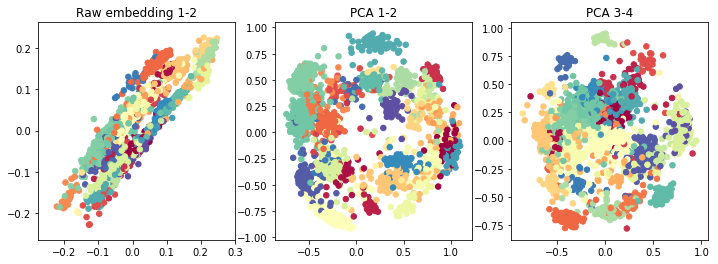

In [95]:
plt.subplot(1,3,1)
plt.title("Raw embedding 1-2")
plt.scatter(embs[:,0],embs[:,1],c=labels, s=30, cmap=plt.cm.Spectral)

pca = PCA()
pemb = pca.fit_transform(embs)

plt.subplot(1,3,2)
plt.title("PCA 1-2")
plt.scatter(pemb[:,0], pemb[:,1], c=labels, s=30, cmap=plt.cm.Spectral)

plt.subplot(1,3,3)
plt.title("PCA 3-4")
plt.scatter(pemb[:,2], pemb[:,3], c=labels, s=30, cmap=plt.cm.Spectral)

plt.gcf().set_size_inches((12,4))
plt.show()


In [96]:
cyrbia = np.mean(embs[labels==7],axis=0)
cythera = np.mean(embs[labels==8],axis=0)

In [97]:
vAB = cythera-cyrbia
N = np.sqrt(np.sum(vAB**2))
vAB = vAB/N

vMean = (cythera+cyrbia)/2.0

coord1 = np.sum(vAB.reshape((1,64))*embs,axis=1)
coord2 = np.sqrt(np.sum( (embs-cyrbia)**2, axis=1))
coord3 = np.sqrt(np.sum( (embs-cythera)**2, axis=1))
coord4 = np.sqrt(np.sum( (embs-vMean)**2, axis=1))

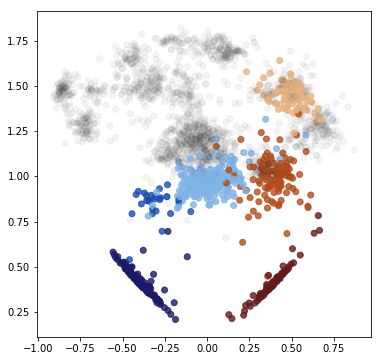

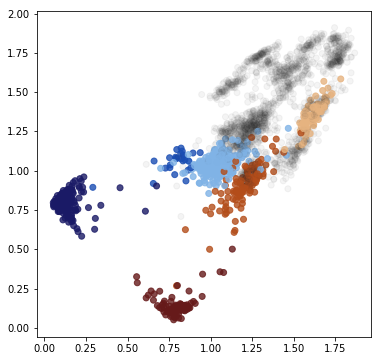

In [98]:
colors = np.ones((labels.shape[0],4))
colors[:,:] = np.array([0.2,0.2,0.2,0.05])

colors[labels==8] = np.array([0.4,0.1,0.1,0.8])
colors[labels==36] = np.array([0.7,0.3,0.1,0.8])
colors[labels==31] = np.array([0.9,0.7,0.5,0.8])

colors[labels==7] = np.array([0.1,0.1,0.4,0.8])
colors[labels==34] = np.array([0.1,0.3,0.7,0.8])
colors[labels==28] = np.array([0.5,0.7,0.9,0.8])
#plt.subplot(1,2,1)
plt.scatter(coord1,coord4,c=colors)
#plt.subplot(1,2,2)
#plt.scatter(coord1,coord3,c=colors)
plt.gcf().set_size_inches((6,6))
plt.show()

plt.scatter(coord2,coord3,c=colors)
plt.gcf().set_size_inches((6,6))
plt.show()

## Training the network

Set TRAIN_NET to True and run. Embeddings will not be identical due to random initialization.

In [7]:
TRAIN_NET = False

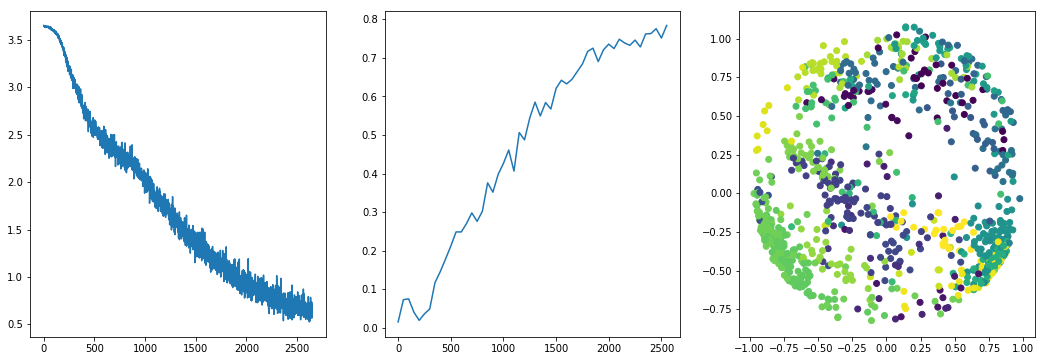

KeyboardInterrupt: 

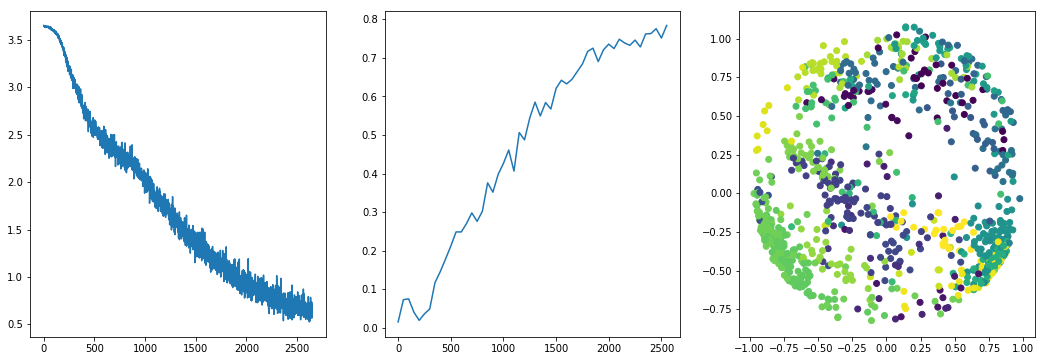

In [14]:
if TRAIN_NET:
    #tr_err = []
    #ts_acc = []
    pca = PCA()
    
    for batch in range(10000):
        b1,b2,b3,l = getBatch(38*3)

        net.train()
        net.zero_grad()

        l = torch.LongTensor(l).cuda()
        p,z1,z2,z3 = net.forward(tovar(b1),tovar(b2),tovar(b3))

        loss = net.loss(p,z1,z2,z3,l)

        tr_err.append(loss.cpu().data.numpy()[0])
        loss.backward()

        net.adam.step()

        net.eval()

        if batch%50 == 49:
            test_embs = []
            test_labels = []
            acc = 0
            count = 0
            for i in range((data.shape[0]-TRAIN)//50):
                batch = tovar(data[i*50+TRAIN:i*50+TRAIN+50])
                l = labels[i*50+TRAIN:i*50+TRAIN+50]
                for l0 in l:
                    test_labels.append(l0)

                z = net.get_embedding(batch)                
                p = net.predict(z).cpu().data.numpy()

                z = z.cpu().data.numpy()
                for zm in z:
                    test_embs.append(zm.copy())
                acc += np.mean(np.argmax(p,axis=1)==l)
                count += 1
            
            test_embs = np.array(test_embs)
            test_labels = np.array(test_labels)
            
            pembs = pca.fit_transform(test_embs)
            
            ts_acc.append(acc/float(count))

            plt.clf()
            plt.subplot(1,3,1)
            plt.plot(tr_err)

            plt.subplot(1,3,2)
            plt.plot(np.arange(len(ts_acc))*50,ts_acc)
            
            plt.subplot(1,3,3)
            plt.scatter(pembs[:,0],pembs[:,1],c=test_labels)
            
            plt.gcf().set_size_inches((18,6))
            
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(0.01)
            torch.save(net.state_dict(), open("retrained_network.pth","wb"))